In [1]:
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy.dynamics import environment_setup, environment, propagation_setup, simulator
from tudatpy.estimation import observable_models_setup,observable_models, observations_setup, observations, estimation_analysis
from tudatpy.astro import element_conversion, time_representation
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tudatpy.data.spacetrack import SpaceTrackQuery
from tudatpy.dynamics import parameters_setup, parameters, propagation, propagation_setup
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

In [2]:
# Load spice standard kernels
spice.load_standard_kernels()

In [3]:
norad_id = 64865
username = 'l.gisolfi@tudelft.nl'
password = 'l.gisolfi*tudelft.nl'

In [4]:
# Initialize SpaceTrackQuery
SpaceTrackQuery = SpaceTrackQuery(username, password)

In [5]:
# OMM Dict
json_dict = SpaceTrackQuery.DownloadTle.single_norad_id(SpaceTrackQuery, norad_id)

In [6]:
# Retrieve TLEs
tle_dict = SpaceTrackQuery.OMMUtils.get_tles(SpaceTrackQuery,json_dict)
tle_line1, tle_line2 = tle_dict[str(norad_id)][0], tle_dict[str(norad_id)][1]

In [7]:
# Retrieve TLE Reference epoch, this will be start epoch of simulation
tle_reference_epoch = SpaceTrackQuery.OMMUtils.get_tle_reference_epoch(SpaceTrackQuery,tle_line1)

In [8]:
number_of_pod_iterations = 6 # number of iterations for our estimation
timestep_global = 60 # timestep of 120 seconds for our estimation
time_buffer = 60 # uncomment only if needed.

In [9]:
# Define Simulation Start and End (Date)Times
observations_start = tle_reference_epoch # set as tle reference epoch for now, but can vary
observations_end = tle_reference_epoch + timedelta(seconds=60*30) # one hour after observation start
float_observations_start = time_representation.DateTime.from_python_datetime(observations_start).to_epoch()
float_observations_end = time_representation.DateTime.from_python_datetime(observations_end).to_epoch()

In [10]:
# define the frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

In [11]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Earth",
    "Moon",
]

In [12]:
# Create system of bodies
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

In [13]:
body_settings.add_empty_settings(str(norad_id))

In [14]:
# create ephemeris for the object via sgp4 ephemeris
original_sgp4_ephemeris =  environment_setup.ephemeris.sgp4(
    tle_line1,
    tle_line2,
    frame_origin = global_frame_origin,
    frame_orientation = global_frame_orientation)

In [15]:
# Creating tabulated ephemeris is required for the Estimator to work.
norad_id_ephemeris = environment_setup.ephemeris.tabulated_from_existing(
    original_sgp4_ephemeris,
    float_observations_start,
    float_observations_end,
    timestep_global)

In [16]:
body_settings.get(str(norad_id)).ephemeris_settings =  environment_setup.ephemeris.tabulated_from_existing(
    original_sgp4_ephemeris,
    float_observations_start,
    float_observations_end,
    timestep_global)

In [17]:
bodies = environment_setup.create_system_of_bodies(body_settings)
initial_state = bodies.get(str(norad_id)).ephemeris.cartesian_state(float_observations_start)

In [18]:
bodies_to_propagate = [str(norad_id)]
central_bodies = [global_frame_origin]

In [19]:
# Create propagator settings
integrator_settings = propagation_setup.integrator. \
    runge_kutta_fixed_step_size(initial_time_step= time_representation.Time(timestep_global),
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)
# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(float_observations_end)

In [20]:
# Define acceleration model
acceleration_settings_on_spacecraft = dict()
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
    ],
    "Earth": [propagation_setup.acceleration.spherical_harmonic_gravity(2,2)],
    "Moon": [propagation_setup.acceleration.spherical_harmonic_gravity(2,2)],
}

In [21]:
# Set up the accelerations settings for each body, in this case only for our norad_id
acceleration_settings = {}
acceleration_settings[str(norad_id)] = accelerations

In [22]:
# create the acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

In [23]:
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=['Earth'],
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_state,
    initial_time=float_observations_start,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition
)

In [24]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = parameters_setup.initial_states(
    propagator_settings, bodies
)
parameters_to_estimate = parameters_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

In [25]:
# Save the true initial state to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
print(f'Truth Parameters: \n {truth_parameters}')

Truth Parameters: 
 [ 2.62232628e+06  6.00699584e+06 -1.47508699e+06  1.63904326e+03
  1.10403636e+03  7.44546700e+03]


In [26]:
# Create light-time corrections list
light_time_correction_list = list()
light_time_correction_list.append(
    observable_models_setup.light_time_corrections.first_order_relativistic_light_time_correction(["Sun"]))

In [27]:
# Define TU Delft Rooftop station and coordinates
reference_point = "TU_DELFT_ROOFTOP"
reference_point_backup = "ARUBA_ROOFTOP"
stations_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

Uncomment to add link end in Aruba
aruba_latitude = np.deg2rad(12.517572)
aruba_longitude = np.deg2rad(-69.9649462)

In [28]:
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    reference_point,
    [stations_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

Uncomment to add link end in Aruba
environment_setup.add_ground_station(
   bodies.get_body("Earth"),
   reference_point_backup,
   [stations_altitude, aruba_latitude, aruba_longitude],
   element_conversion.geodetic_position_type)

In [29]:
link_ends_list = [{observable_models_setup.links.receiver: observable_models_setup.links.body_reference_point_link_end_id('Earth', reference_point),
                   observable_models_setup.links.transmitter: observable_models_setup.links.body_origin_link_end_id(str(norad_id))}]

                  # Add this to the list if probing with link end in Aruba
                  #{observable_models_setup.links.receiver: observable_models_setup.links.body_reference_point_link_end_id('Earth', reference_point_backup),
                  # observable_models_setup.links.transmitter: observable_models_setup.links.body_origin_link_end_id(str(norad_id))}, ]

In [30]:
# Create Link Ends
link_definition_list = []
for link_ends in link_ends_list:
    link_definition_list.append(observable_models_setup.links.link_definition(link_ends))
observation_model_settings = list()

In [31]:
# Create observation model settings
for link_definition in link_definition_list:
    observation_model_settings.append(observable_models_setup.model_settings.angular_position(
        link_definition, light_time_correction_list))

In [32]:
# Create observations times. Results of the estimation slightly depend on this time buffer.
# Consider exploring why things do not work with time_buffer = 0
observation_times = np.arange(float_observations_start + time_buffer, float_observations_end - time_buffer, timestep_global)
observation_simulation_settings = list()
body_state_history = dict()

In [33]:
# Create Simulation (propagation) Settings
for link_definition in link_definition_list:
    observation_simulation_settings.append(observations_setup.observations_simulation_settings.tabulated_simulation_settings(
        observable_models_setup.model_settings.angular_position_type,
        link_definition,
        observation_times))

In [34]:
# Add random noise to the observations
noise_level = 1e-6 # typical astrometry error for detection is around 1 arcsec, corresponding to 1e-6 radians.
observations_setup.random_noise.add_gaussian_noise_to_observable(
    observation_simulation_settings,
    noise_level,
    observable_models_setup.model_settings.angular_position_type
)

In [35]:
# Create observation simulators
observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(observation_model_settings, bodies)

In [36]:
# Retrieve observation collection
norad_id_simulated_observations = observations_setup.observations_wrapper.simulate_observations(
    observation_simulation_settings,
    observation_simulators,
    bodies)

Add weights to the observation collection
(if not set, default = 1 [radians]. This would be too big!)
When using radio links, default = 1 [m]. In that case, that would be fine...

In [37]:
norad_id_simulated_observations.set_constant_weight(noise_level)

In [38]:
# Compute and set residuals in the compressed observation collection
observations.compute_residuals_and_dependent_variables(norad_id_simulated_observations, observation_simulators, bodies)

In [39]:
# Filter residual outliers (if any)
norad_id_simulated_observations.filter_observations(
    observations.observations_processing.observation_filter(observations.observations_processing.residual_filtering, 0.1))

In [40]:
# Retrieve relevant quantities (observations, residuals, observation times) from observation collection
concatenated_observations = norad_id_simulated_observations.concatenated_observations
concatenated_residuals = norad_id_simulated_observations.get_concatenated_residuals()
concatenated_times= norad_id_simulated_observations.concatenated_times

In [41]:
# Separate Ra and Dec coordinates (they are found together in concatenated observations)
concatenated_ra = concatenated_observations[::2]
concatenated_dec = concatenated_observations[1::2]

In [42]:
# Convert to degrees
concatenated_ra_deg = [np.rad2deg(ra) for ra in concatenated_ra]
concatenated_dec_deg = [np.rad2deg(dec) for dec in concatenated_dec]

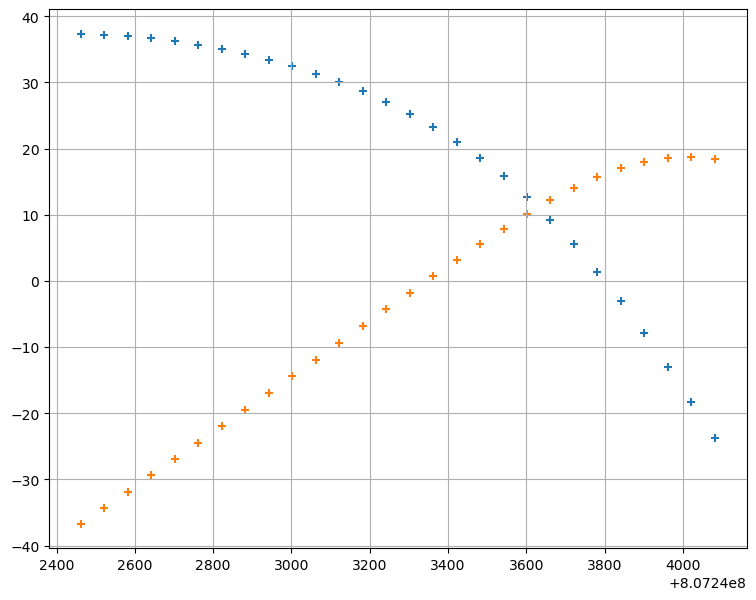

In [43]:
# plot the residuals, split between RA and DEC types
# Plot observations
fig, axs = plt.subplots(
    1,
    1,
    figsize=(9, 7),
    sharex=True,
    sharey=False,
)
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    ax.scatter(
        concatenated_times[::2],
        concatenated_ra_deg,
        marker="+",
        s=40,
        label="Right Ascension",
    )

    ax.scatter(
        concatenated_times[::2],
        concatenated_dec_deg,
        marker="+",
        s=40,
        label="Declination",
    )

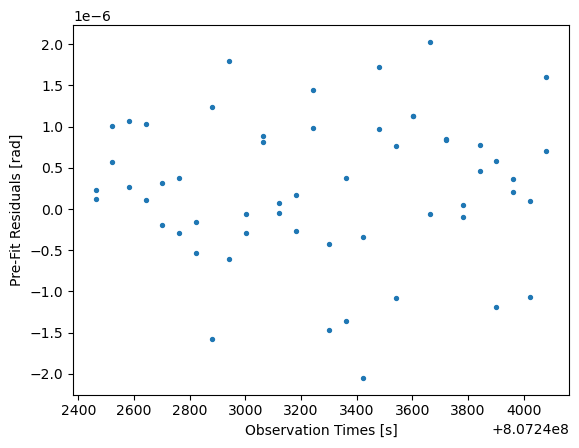

In [71]:
# Plot PRE-FIT Residuals
plt.scatter(concatenated_times,concatenated_residuals, s = 8)
plt.xlabel('Observation Times [s]')
plt.ylabel('Pre-Fit Residuals [rad]')
plt.show()

In [45]:
# Set up the estimator
estimator = estimation_analysis.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_model_settings,
    propagator_settings=propagator_settings,
)

In [46]:
# provide the observation collection as input, and limit number of iterations for estimation.
estimation_input = estimation_analysis.EstimationInput(
    observations_and_times=norad_id_simulated_observations,
    convergence_checker=estimation_analysis.estimation_convergence_checker(
        maximum_iterations=10,
    ),
)

In [72]:
# Set estimation methodological options
estimation_input.define_estimation_settings(save_state_history_per_iteration = True, reintegrate_variational_equations=True)

In [73]:
# Perform the estimation
estimation_output = estimator.perform_estimation(estimation_input)

Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update-1.72508e-09 -1.73218e-09  3.90829e-10  5.27913e-13   3.6951e-12 -6.12793e-13
Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update 3.44743e-09  3.93068e-09 -1.45224e-09 -2.68654e-12 -9.10592e-12 -9.83922e-13
Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update-1.30098e-09  -1.9862e-09  2.02008e-10  2.99673e-12  5.36034e-12  9.12959e-13
Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update-6.31008e-10 -9.88737e-10  1.83051e-09 -5.88013e-13  2.71595e-12 -1.48449e-12
Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update 2.15863e-09  3.47109e-09 -2.65316e-09 -1.57499e-12 -8.46062e-12  3.19085e-12
Calculating residuals and partials 56
Current residual: 8.53222e-07
Parameter update-6.30413e-10 -1.66256e-09  1.27428e-09  4.00035e-13  2.43804e-12 -2.35946e-12
Calculating residuals and pa

retrieve the estimated initial state and compare it to the truth.

In [79]:
initial_state_updated = parameters_to_estimate.parameter_vector
print('Done with the estimation...\n')
print(f'Updated initial state:\n {initial_state_updated}\n')
vector_error_final = (np.array(initial_state_updated) - truth_parameters)[0:3]
error_magnitude_final = np.linalg.norm(vector_error_final)/1000
print(
    f"{norad_id} final error to TLE initial state: {round(error_magnitude_final, 2)} km\n"
)

Done with the estimation...

Updated initial state:
 [ 2.62231123e+06  6.00699079e+06 -1.47506438e+06  1.63901625e+03
  1.10398852e+03  7.44546720e+03]

64865 final error to TLE initial state: 0.03 km



In [53]:
# These three lines might be useful later when adding multiple parameters to estimate
simulator_object = estimation_output.simulation_results_per_iteration[-1]
state_history = simulator_object.dynamics_results.state_history
dependent_variable_history = simulator_object.dynamics_results.dependent_variable_history

In [54]:
# Plot the propagated orbit and highlight truth vs estimated state
ephemeris_state = list()
for epoch in state_history.keys():
    ephemeris_state.append(state_history[epoch])

In [55]:
# Extract x, y, z components
x_values = [state[0]/1000 for state in ephemeris_state]
y_values = [state[1]/1000 for state in ephemeris_state]
z_values = [state[2]/1000 for state in ephemeris_state]

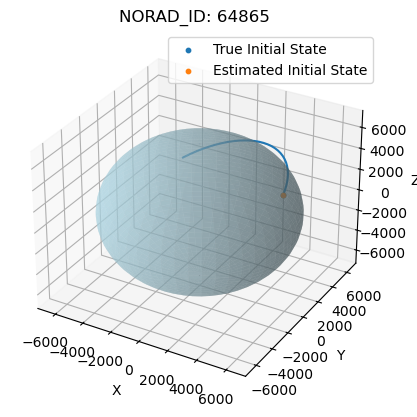

In [56]:
# Create 3D figure and plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_values, y_values, z_values)
SpaceTrackQuery.OMMUtils.plot_earth(SpaceTrackQuery, ax)
ax.scatter(initial_state[0]/1000, initial_state[1]/1000, initial_state[2]/1000, label ='True Initial State', s = 10)
ax.scatter(initial_state_updated[0]/1000, initial_state_updated[1]/1000, initial_state_updated[2]/1000, label ='Estimated Initial State', s = 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'NORAD_ID: {str(norad_id)}')
ax.legend()
plt.show()

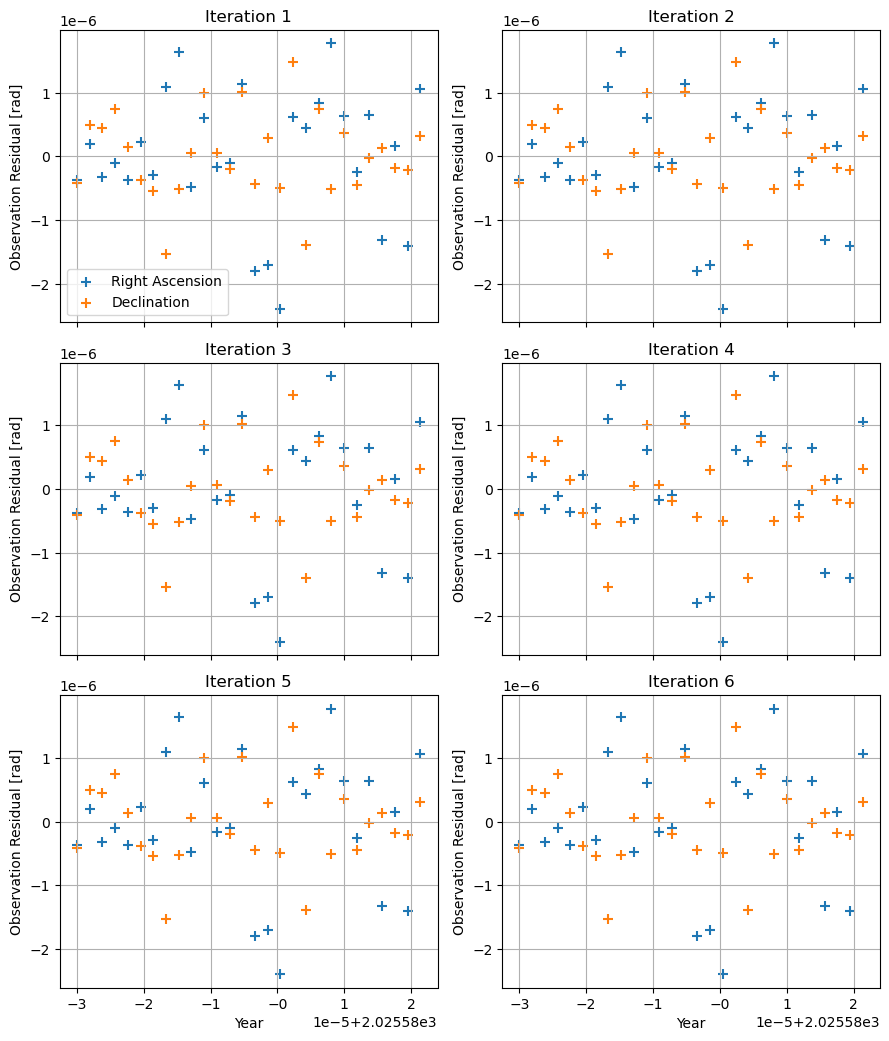

In [84]:
# Print Residuals History
residual_history = estimation_output.residual_history
# Number of columns and rows for our plot
number_of_columns = 2
number_of_rows = (
    int(number_of_pod_iterations / number_of_columns)
    if number_of_pod_iterations % number_of_columns == 0
    else int((number_of_pod_iterations + 1) / number_of_columns)
)
fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)
# We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
residual_times = (
        np.array(norad_id_simulated_observations.concatenated_times) / (86400 * 365.25) + 2000
)
# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    # we take every second
    ax.scatter(
        residual_times[::2],
        residual_history[
        ::2,
        idx,
        ],
        marker="+",
        s=60,
        label="Right Ascension",
    )
    ax.scatter(
        residual_times[1::2],
        residual_history[
        1::2,
        idx,
        ],
        marker="+",
        s=60,
        label="Declination",
    )
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()
# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Year")

axs[0, 0].legend()
plt.show()

In [67]:
# Retrieve and plot correlation matrix
# Correlation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation_analysis.CovarianceAnalysisInput(norad_id_simulated_observations)
covariance_output = estimator.compute_covariance(covariance_input)

Calculating residuals and partials 56


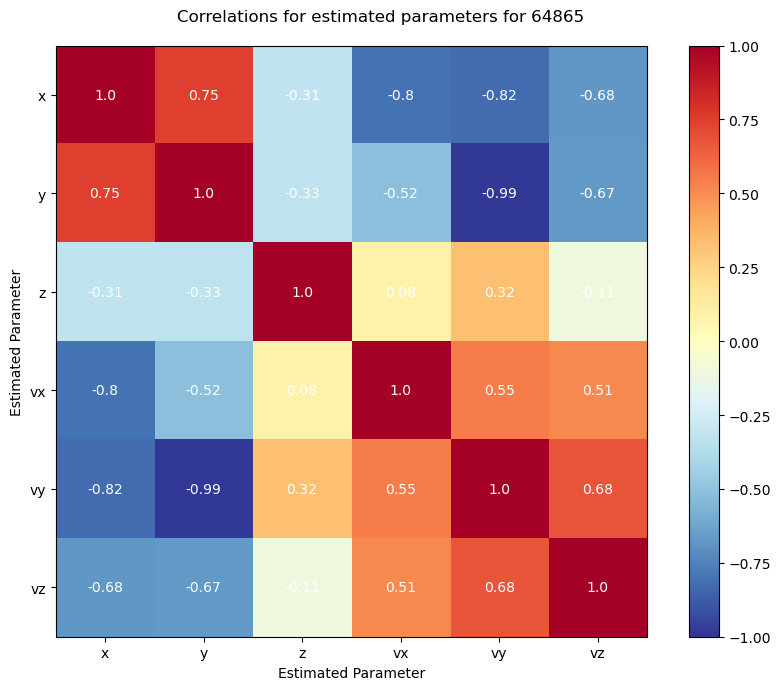

In [86]:
correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 2), ha="center", va="center", color="w"
        )
cb = plt.colorbar(im)
ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")
fig.suptitle(f"Correlations for estimated parameters for {norad_id}")
fig.set_tight_layout(True)
plt.show()